In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras import optimizers
from sklearn.metrics import hamming_loss
from sklearn import metrics
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,average_precision_score,label_ranking_loss
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dropout
from keras.callbacks import LambdaCallback
from sklearn.metrics import roc_auc_score
def metric_cal(y_test,yhat):
    yhat2 =yhat+.1 
    yhat2 = yhat2.round()
    
    mac_f1=f1_score(y_test, yhat2, average='macro')

    avg_percision=average_precision_score(y_test.T, yhat.T)
    avg_percision2=average_precision_score(y_test , yhat )
    hm_loss=hamming_loss(y_test.T, yhat2.T)
    hm_loss2=hamming_loss(y_test, yhat2)

    R_loss=label_ranking_loss(y_test.T, yhat.T)
    R_loss2=label_ranking_loss(y_test, yhat)
    mac_roc=roc_auc_score(y_test, yhat, average='macro')
    mac_roc1=roc_auc_score(y_test.T, yhat.T, average='macro')
    #squared_difference=tfa.metrics.hamming_loss_fn((y_test),yhat, mode="multilabel", threshold=.7)
    print("MacF1:",mac_f1," avg_percision:",avg_percision,avg_percision2,
          " Hamming loss:", hm_loss,hm_loss2,"ranking_loss:",R_loss,R_loss2 ," mac_roc:",mac_roc,mac_roc1 )
    
def read_rm_features(path,i):
    f = open(path+"/rm_features"+str(i)+".csv", "r")
    xx=f.read()
    x = xx.split(",")
  
    return x

def read_data(path):
    
    df_train = pd.read_csv(path+"train.csv")
    print("before:",df_train.shape)
    removing_features=read_rm_features(path,5.0)
    df_train=df_train.drop(removing_features,axis=1)
    df_train_x=df_train.iloc[:,:-6]
    df_train_y=df_train.iloc[:,-6:]
    
    df_test = pd.read_csv(path+"test.csv")
    df_test=df_test.drop(removing_features,axis=1)
    df_test_x=df_test.iloc[:,:-6]
    df_test_y=df_test.iloc[:,-6:]
    print(df_train.shape)
    
    return df_train_x,df_train_y,df_test_x,df_test_y

 








def evaluate_model(X_train,y_train, X_test,y_test):
    results = list()
    n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]

    model = get_model(n_inputs, n_outputs)
    model.fit(X_train, y_train, verbose=1, epochs=100)
    yhat = model.predict(X_test)
    yhat = yhat.round()
    acc = accuracy_score(y_test, yhat)
    # store result
    
    print('>%.3f' % acc)
    results.append(acc)
    return results,model,yhat

def costum_model(train_x,train_y,epochs, batch_size,Optimizer,output,weights):
    LR=0.001
    Optimizer = optimizers.Adam(learning_rate=0.001)
    dim_x,dim_y=train_x.shape
    input_net=[]
     
    input_net=Input(shape=(dim_y,) )
    # the first branch operates on the first input
    hidden_layer=[]
    for i in range (label_size):
        x = Dense(128, activation="relu")(input_net )
        
        x = Dense(64, activation="relu")(x)
        x = Dense(16, activation="relu")(x)
        x = Dense(1, activation="sigmoid")(x)
        x = Model(inputs=input_net , outputs=x)
        
        hidden_layer.append(x)



    out=[]
    for a in hidden_layer:
        out.append(a.output)

    combined = concatenate( out     )

    z = Dense(6, trainable=False,activation="relu")(combined)


   

    
    model = Model(inputs=input_net, outputs=z)
    model.layers[26].set_weights(weights)
    return model

def Emotion_model(train_x,train_y,epochs, batch_size,Optimizer,output,weights):
    
 
    model=costum_model(train_x,train_y,epochs, batch_size,Optimizer,output,weights)
    model.compile(loss=my_loss_fn, optimizer=Optimizer, metrics=["accuracy"])
     
    #model.compile(loss=my_loss_fn, optimizer=Optimizer, metrics=["accuracy"])
    
    model.fit(train_x,   train_y,epochs, batch_size  ) 
    return model

def probab(y_train):
    s = (y_train.shape[1],y_train.shape[1])
    PROB=np.zeros(s)
    
    for j in range (y_train.shape[1]):
        tmp=np.zeros(y_train.shape[1])
        count=0
        for i in range (y_train.shape[0]):
            tmp+=y_train.iloc[i].values*y_train.iloc[i].values[j]
            count+=y_train.iloc[i].values[j]
        tmp=tmp/count
        PROB[j]=tmp
            
    return (PROB)
    
    
import keras.backend as K   

##############################
def my_loss_fn(y_true, y_pred):
    
    Gy=tf.get_static_value(y_true)
    Py=tf.get_static_value(y_pred)
    PR=tf.convert_to_tensor(PROB , dtype=tf.float32)
    c=tf.matmul(y_pred,PR)
    
    
    y_true = K.cast(y_true,"float")
    squared_difference=tf.square((y_true)- (y_pred)   )  
    #squared_difference   += tf.square( (y_true - c ))   
    #squared_difference/=2

    
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`


X_train,y_train, X_test,y_test=read_data("../Scene/")
PROB=probab(y_train)
PROB2=np.around(PROB)


PR=tf.convert_to_tensor(  PROB, dtype=tf.float32)
#results,model,yhat = evaluate_model(X_train,y_train, X_test,y_test)

model=Emotion_model(X_train,y_train,100,100,"Adam",y_train.shape[1],[ PROB.T   ,PROB[0]*0   ])


yhat = model.predict(X_test )
print("yhat",yhat)
print(y_test)

metric_cal(y_test,yhat)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

before: (1211, 300)


FileNotFoundError: [Errno 2] No such file or directory: '../Scene//rm_features5.0.csv'

In [512]:
model.layers[26].get_weights()[1]

array([0., 0., 0., 0., 0., 0.], dtype=float32)

In [107]:
PROB2

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [194]:
PROB 

array([[1.        , 0.        , 0.        , 0.        , 0.09251101,
        0.05286344],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , 0.04060914, 0.03045685,
        0.        ],
       [0.        , 0.        , 0.04081633, 1.        , 0.1377551 ,
        0.00510204],
       [0.07581227, 0.        , 0.02166065, 0.09747292, 1.        ,
        0.00361011],
       [0.05357143, 0.        , 0.        , 0.00446429, 0.00446429,
        1.        ]])

In [574]:
PP

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.]])

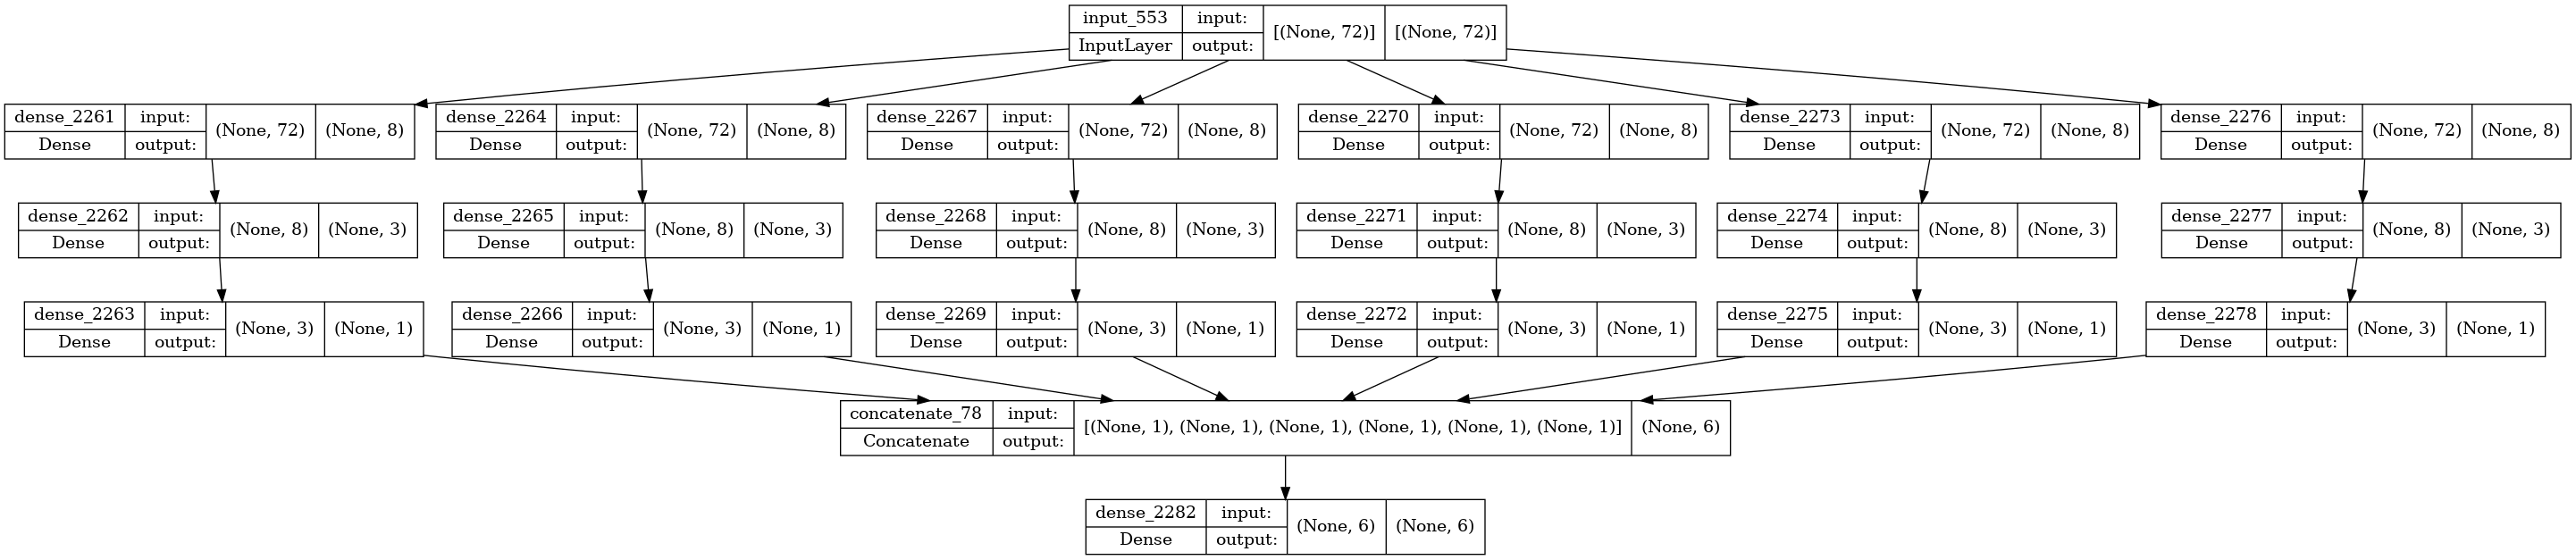

In [389]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
import numpy as np
import argparse
import locale
import os
# define two sets of inputs
dim_y=72
inputA = Input(shape=(dim_y,))
inputB = Input(shape=(128,))
label_size=6

input_net=[]
for i in range (label_size):
    input_net.append(Input(shape=(dim_y,) ))
# the first branch operates on the first input
hidden_layer=[]
for i in range (label_size):
    x = Dense(8, activation="relu")(input_net[0])
    x = Dense(3, activation="relu")(x)
    x = Dense(1, activation="relu")(x)
    x = Model(inputs=input_net[0], outputs=x)
    hidden_layer.append(x)


# the second branch opreates on the second input
y = Dense(64, activation="relu")(input_net[1])
y = Dense(32, activation="relu")(y)
y = Dense(1, activation="relu")(y)
y = Model(inputs=input_net[1], outputs=y)
# combine the output of the two branches
out=[]
for a in hidden_layer:
    out.append(a.output)
    
combined = concatenate( out     )
#combined = concatenate([hidden_layer[0].output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(6, activation="relu")(combined)


#z = Dense(7, activation="linear")(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=input_net, outputs=z)

#model.set_weights(weights)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [379]:
(model.layers[25].get_weights())


[array([[1.        , 0.        , 0.        , 0.        , 0.09251101,
         0.05286344],
        [0.        , 1.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 1.        , 0.04060914, 0.03045685,
         0.        ],
        [0.        , 0.        , 0.04081633, 1.        , 0.1377551 ,
         0.00510204],
        [0.07581227, 0.        , 0.02166065, 0.09747292, 1.        ,
         0.00361011],
        [0.05357143, 0.        , 0.        , 0.00446429, 0.00446429,
         1.        ]], dtype=float32),
 array([0., 0., 0., 0., 0., 0.], dtype=float32)]

In [378]:
model.layers[25].set_weights([PROB    ,PROB[0]*0   ])

In [ ]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X_train,y_train, X_test,y_test=read_data("../Scene/")
for i in range(y_train.shape[1]):
    y=y_train.iloc[:,i:i+1]
    print(y)
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=5, step=1)
    selector = selector.fit(X_train, y)
    selector.support_


    selector.ranking_

before: (1211, 300)
(1211, 184)
      Beach
0         1
1         1
2         1
3         1
4         1
...     ...
1206      0
1207      0
1208      0
1209      0
1210      0

[1211 rows x 1 columns]


/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

      Sunset
0          0
1          0
2          0
3          0
4          0
...      ...
1206       0
1207       0
1208       0
1209       0
1210       0

[1211 rows x 1 columns]


/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

      FallFoliage
0               0
1               0
2               0
3               0
4               0
...           ...
1206            0
1207            0
1208            0
1209            0
1210            0

[1211 rows x 1 columns]


/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sajjad/Python-3.8.0/exit/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d arr

In [ ]:
y=y_train.iloc[:,0:1]
y

In [ ]:
X_train